<a href="https://colab.research.google.com/github/malekkhaled/Coursera_Capstone/blob/main/Segmenting_and_Clustering_Neighborhoods_in_Toronto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import all libraries needed

In [ ]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup


<b>Use Beautiful Soup packge to scrape our wikipedia page.</b>
<br>Going through each td element we store the postal code, Borough, and Neighbourhood in a list of dictionaries and then transform it to a pandas dataframe.


In [ ]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(url)

soup = BeautifulSoup(page.content, 'html.parser')

table_contents=[]
table=soup.find('table')

for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

df.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


Getting the number of rows and columns in our dataframe.

In [ ]:
df.shape

(103, 3)

In [57]:
df_coord = pd.read_csv('/content/Geospatial_Coordinates.csv')
df_coord

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [69]:
neighborhoods = pd.merge(df, df_coord, left_on='PostalCode', right_on='Postal Code').drop(columns=['Postal Code'])

In [70]:
neighborhoods.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [61]:
from sklearn.cluster import KMeans
import folium 

In [64]:
from geopy.geocoders import Nominatim
address = "Toronto, Canada"
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.6534817, -79.3839347.


In [74]:
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)


for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

Github does not show maps so I had to include an image of it.

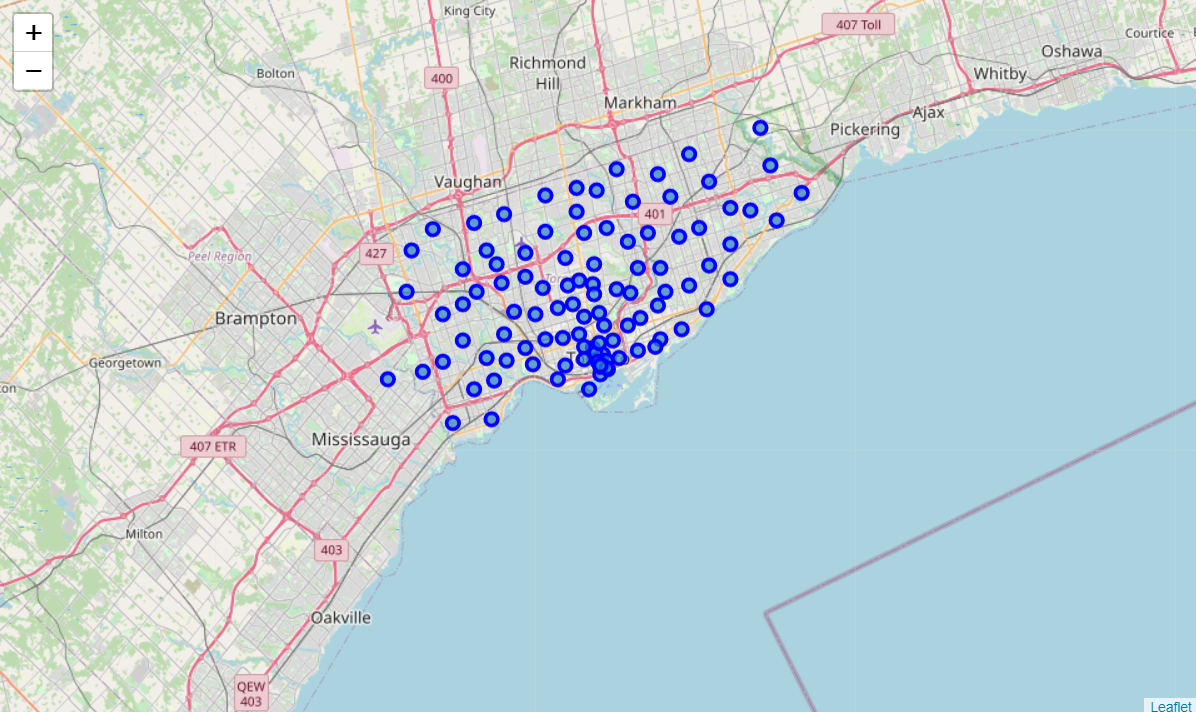